In [143]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.io as sio
from pandas import Series
import scipy.fftpack
from scipy import signal
from termcolor import colored

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

(2, 1281, 500)


Text(0.5, 1.0, 'Average time series')

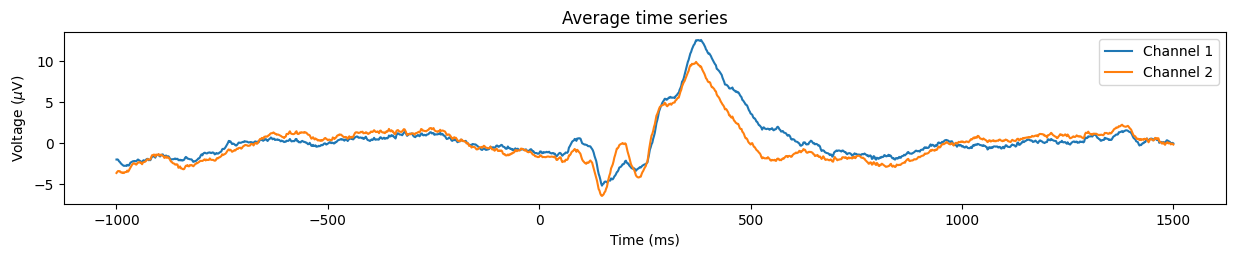

In [144]:
# import data
matdat = sio.loadmat('SNRdata.mat')
timevec = np.squeeze( matdat['timevec'] )
eegdata = matdat['eegdata']
print(eegdata.shape)

# plot mean and std data time series
plt.subplot(211)
plt.plot(timevec,np.mean(eegdata,2).T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage ($\mu$V)')
plt.legend(['Channel 1','Channel 2'])
plt.title('Average time series')

In [145]:
## alternative: SNR at a point

# pick time point
timepoint = 375
basetime  = [-500, 0]

# convert baseline time window to indices


# average over repetitions
erp = np.mean(eegdata,2)
print(eegdata.shape)
print(erp.shape)
bidx1 = np.argmin((timevec-basetime[0])**2)
bidx2 = np.argmin((timevec-basetime[1])**2)


# SNR components
snr_num = erp[:,np.argmin((timevec-timepoint)**2)]
snr_den = np.std( erp[:,range(bidx1,bidx2)] ,1)



# display SNR in the command window
print('SNR at %d ms in channel 1 = %g' %(timepoint,snr_num[0]/snr_den[0]) )
print('SNR at %d ms in channel 2 = %g' %(timepoint,snr_num[1]/snr_den[1]) )


(2, 1281, 500)
(2, 1281)
SNR at 375 ms in channel 1 = 17.9399
SNR at 375 ms in channel 2 = 9.25177


(1281,)


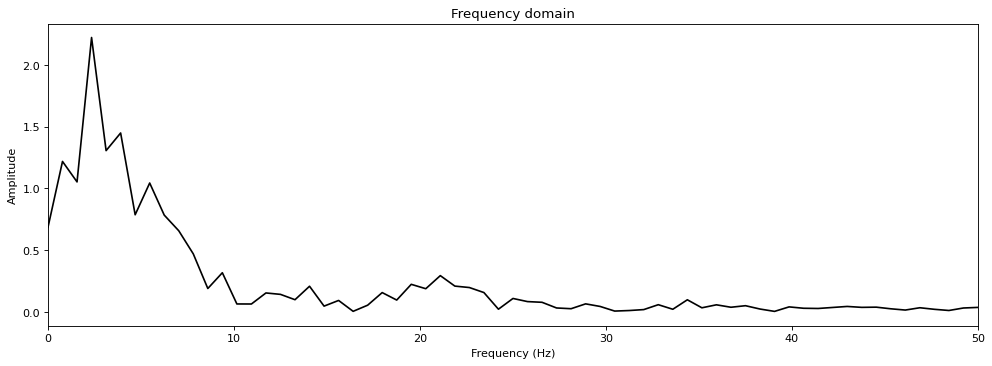

In [146]:

## Generate a multispectral noisy signal
aaa = np.mean(eegdata,2)[0]

# simulation parameters
srate = 1000 # in Hz
fs = srate
npnts = len(aaa)
#print(time)
print(timevec.shape)


eegdataX = scipy.fftpack.fft(aaa)
eegdataAmp = 2*np.abs(eegdataX)/npnts

# vector of frequencies in Hz
hz = np.linspace(0,srate/2,int(np.floor(npnts/2)+1))

## plots
from matplotlib.pyplot import figure
figure(figsize=(15, 5), dpi=80)



plt.plot(hz,eegdataAmp[0:len(hz)],'k')
plt.xlim([0,50])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Frequency domain')
plt.show()

SNR at 375 ms in channel 1 = 15.6277
SNR at 375 ms in channel 2 = 6.26984


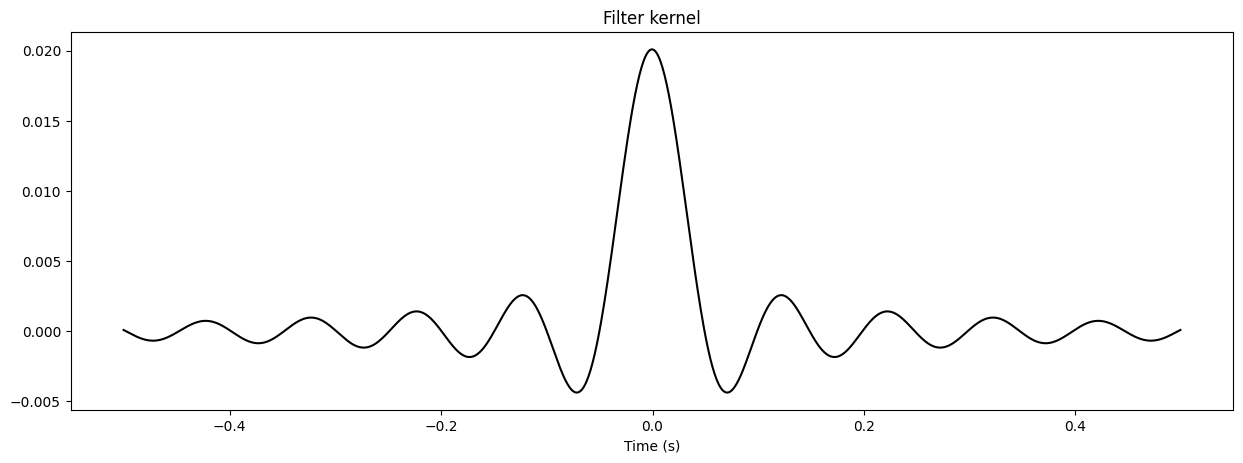

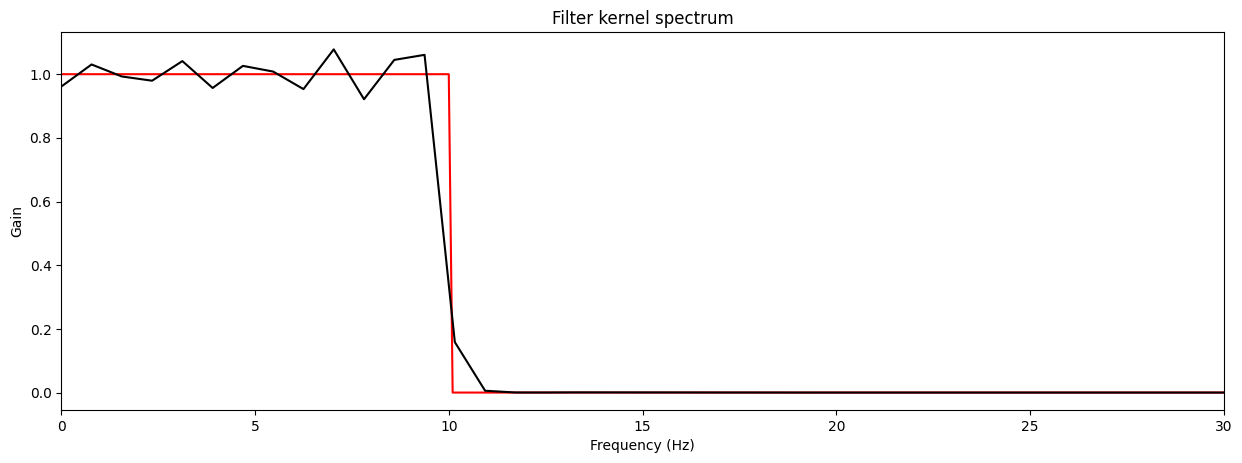

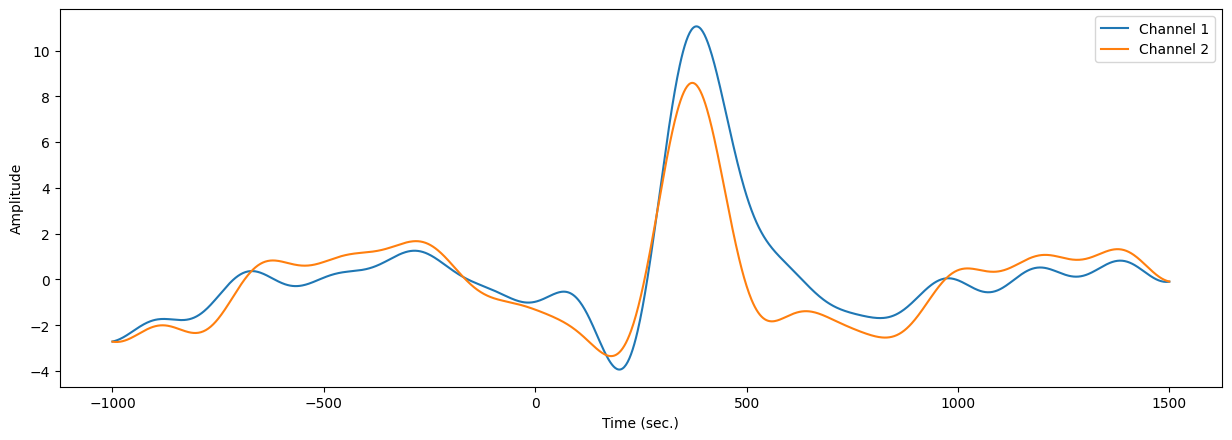

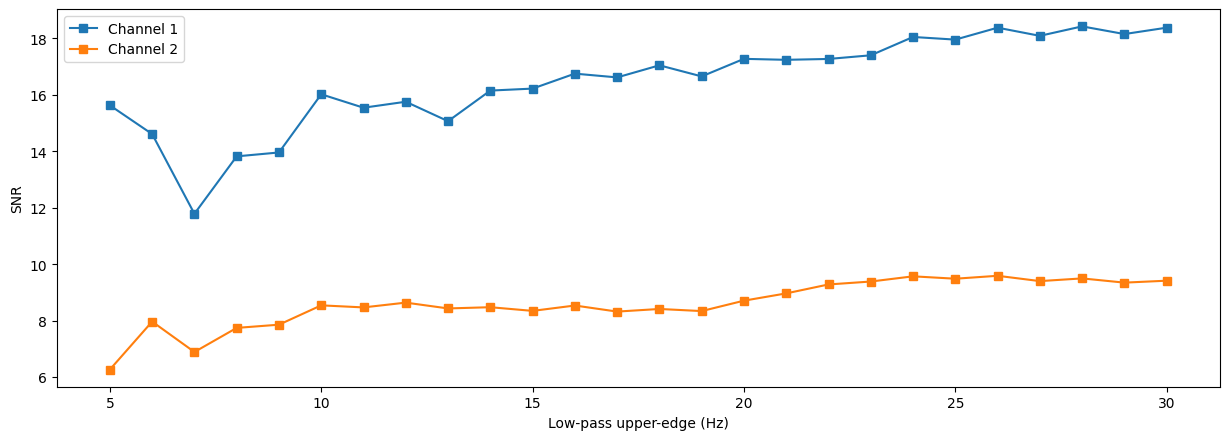

In [232]:
## now for lowpass filter
meanEegData =  np.mean(eegdata,2)
snrList = []
freqList = []

for i in range(5,30+1):
  fcutoff = i
  transw  = .01
  order   = 1001
  freqList.append(i)
  shape   = [ 1,1,0,0 ]
  frex    = [ 0, fcutoff, fcutoff+fcutoff*transw, fs/2 ]

  # filter kernel
  filtkern = signal.firls(order,frex,shape,fs=fs)

  # its power spectrum
  filtkernX = np.abs(scipy.fftpack.fft(filtkern,npnts))**2

  meanEegData_reflected = np.concatenate(( np.flip(meanEegData), meanEegData, np.flip(meanEegData)), axis=1)
  #print(meanEegData_reflected.shape)
  ### now apply the filter to the data
  filted1 = signal.filtfilt(filtkern,1,meanEegData_reflected[0])[len(meanEegData[0]):len(meanEegData[0])*2]
  filted2 = signal.filtfilt(filtkern,1,meanEegData_reflected[1])[len(meanEegData[1]):len(meanEegData[1])*2]
  filted = np.array([filted1,filted2])


  if i == 10:
    plt.plot(np.arange(-order/2,order/2)/fs,filtkern,'k')
    plt.xlabel('Time (s)')
    plt.title('Filter kernel')
    plt.show()

    plt.plot(np.array(frex),shape,'r')
    plt.plot(hz,filtkernX[:len(hz)],'k')
    plt.xlim([0,30])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.title('Filter kernel spectrum')
    plt.show()

    plt.plot(timevec,filted.T)
    plt.legend(['Channel 1','Channel 2'])
    plt.xlabel('Time (sec.)')
    plt.ylabel('Amplitude')
    plt.show()

  # pick time point
  timepoint = 375
  basetime  = [-500, 0]


  # average over repetitions
  erp = filted
  bidx1 = np.argmin((timevec-basetime[0])**2)
  bidx2 = np.argmin((timevec-basetime[1])**2)

  # SNR components
  snr_num = erp[:,np.argmin((timevec-timepoint)**2)]
  snr_den = np.std( erp[:,range(bidx1,bidx2)] ,1)


  if i == 5:
    # display SNR in the command window
    print('SNR at %d ms in channel 1 = %g' %(timepoint,snr_num[0]/snr_den[0]) )
    print('SNR at %d ms in channel 2 = %g' %(timepoint,snr_num[1]/snr_den[1]) )
  snrList.append([snr_num[0]/snr_den[0], snr_num[1]/snr_den[1]])

plt.plot(freqList, snrList, 's-')
plt.legend(['Channel 1','Channel 2'])
plt.xlabel('Low-pass upper-edge (Hz)')
plt.ylabel('SNR')
plt.show()